# Graph Analysis and Visualization Tools in Cytoscape/Notebook Ecosystem

![title](https://www.timlrx.com/_next/image?url=%2Fstatic%2Fimg%2Fgraph_libraries.png&w=3840&q=75)

[(From this page)](https://www.timlrx.com/blog/benchmark-of-popular-graph-network-packages-v2)

## Lab Meeting (1/26/2022)
Keiichiro Ono (Ideker Lab Software Team)

## Background

### Transition to the web

- We are in the middle of the 
- Support for both:
    - Casual users

Today, notebook applications are the primary workbench for (data) scientists. 

## Topics Covered


## TL;DR
    - There is no "one-size-fits-all" solution for network analysis and visualization
    - You need to use multiple tools for
    - Because of this problem, there is a room for new toolkit for the Cytoscape Ecosystem


## Hands-on
- Install [Docker Desktop](https://www.docker.com/products/docker-desktop)
* Clone this repository
* Run the following command to start notebook


In [1]:
!python3 --version

Python 3.9.5


In [1]:
from graph_tool.all import *
import json
import ndex2

import ipycytoscape
import ipywidgets as widgets
import networkx as nx

import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused


# Data Import from NDEx

## NDEx2 Python client

You can use _ndex2_ Python client library for directly fetching network data from [NDEx](https://www.ndexbio.org)

### Import Data

#### TODO: Add search client for complete headless operation

In [4]:
import json
import ndex2

COVID_PPI_UUID = '6398ce70-cee6-11ea-aaef-0ac135e8bacf'

# Create NDEx2 python client
nc2 = ndex2.client.Ndex2()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
response1 = nc2.get_network_as_cx_stream(COVID_PPI_UUID)

# Convert downloaded network to NiceCXNetwork object
cov_cx = ndex2.create_nice_cx_from_raw_cx(json.loads(response1.content))

# Display information about network and output 1st 100 characters of CX
cov_cx.print_summary()

In [4]:
# Create Networkx network
nx_graph = cov_cx.to_networkx(mode='default')

# Then converto to DF
df = nx.to_pandas_edgelist(nx_graph)

# To DOT (Graphviz format)
DOT1 = 'temp-prepared.dot'
nx.nx_agraph.write_dot(nx_graph, DOT1)

In [7]:
# Create a graph-tool network object
gt_1 = load_graph(DOT1)

In [8]:
# apply layout
pos1 = sfdp_layout(gt_1)


In [14]:
# Visualize it
import matplotlib
graph_draw(gt_1, pos1, output_size=(1000, 1000), vertex_color=[10,1,1,0],
           vertex_size=2, edge_pen_width=0.2,
           vcmap=matplotlib.cm.gist_heat_r, output="covid2.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90b29cb5e0, at 0x7f90b34417f0>

In [23]:
state = minimize_nested_blockmodel_dl(gt_1)

In [24]:
state.draw(output="covid-clustered.png")


(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90b29cb5e0, at 0x7f90b74f75e0>,
 <Graph object, directed, with 4824 vertices and 4823 edges, at 0x7f90b71c13a0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90b71c13a0, at 0x7f90b3621610>)

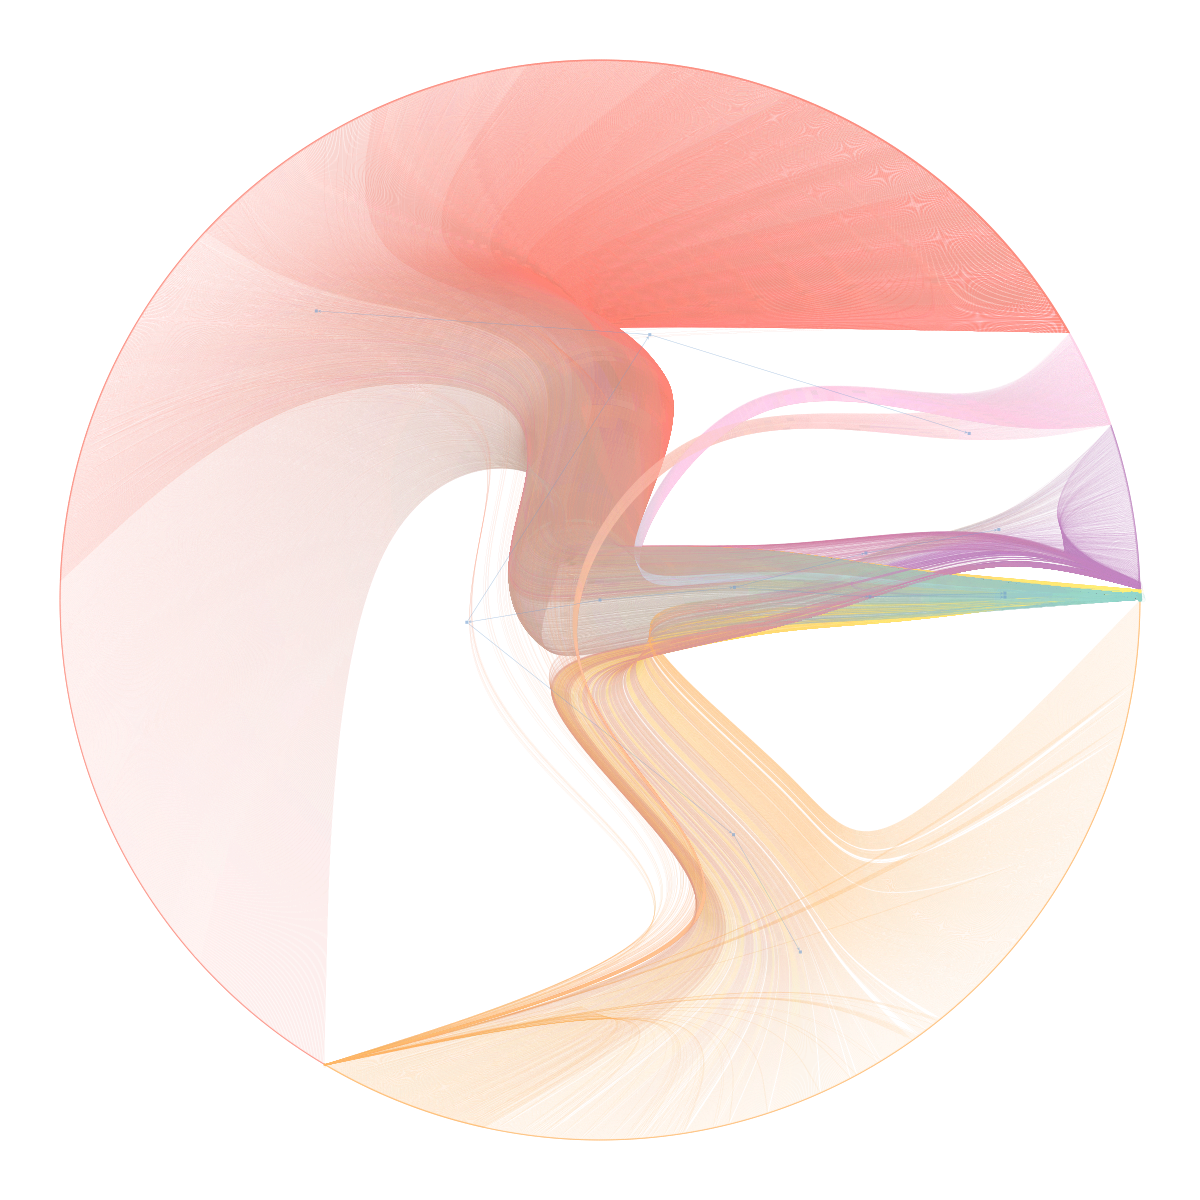

In [25]:
from IPython import display
display.Image("./covid-clustered.png")

### Interactrive Visualization

In [3]:
viz1 = ipycytoscape.CytoscapeWidget()
viz1.graph.add_graph_from_networkx(nxg1)
viz1.set_layout(name='preset')
display(viz1)

CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'css': {'background…

### Problem:
- Visual Style is missing
- Interactivity
  - Editing style

# NetworkX
## Pros
    - Easy to install
    - Well documented
    - A lot of utility functions
        - Data conversion
        - I/O supports most of the existing graph formats

## Cons
### - Extremely slow

In [4]:
widgets.IntSlider()

IntSlider(value=0)

In [3]:
g = Graph()

G = nx.complete_graph(5)
undirected = ipycytoscape.CytoscapeWidget()
undirected.graph.add_graph_from_networkx(G)
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

## Data-Driven styling

### Limitation
Currently, there is no high-level, interactive toolkit to generate data-driven styles

- What kind of features do we need?




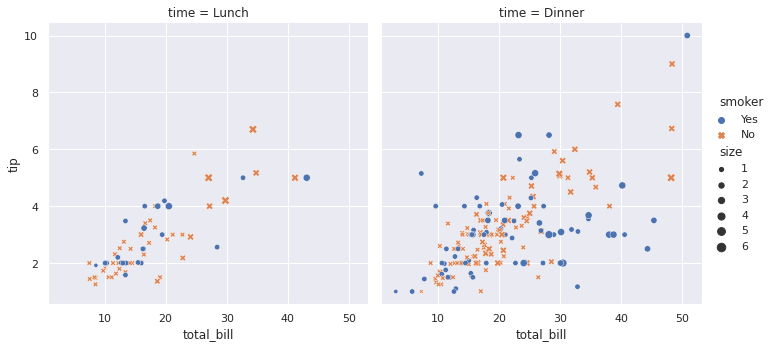

In [3]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

In [5]:
pal1 = sns.color_palette()

In [7]:
pal2 = sns.color_palette("magma", as_cmap=True)

In [17]:
len(pal1)

10

# Summary

## Recommendations for task types

### Data Format Conversion / Data Wrangling
    - NetworkX
    - Pandas
    
### 